In [3]:
import kwant
import numpy as np
from cmath import exp
from math import pi, sqrt, tanh
# For plotting
# %run matplotlib_setup.ipy
import matplotlib.pyplot as plt
from ipywidgets import interact
import time
import sys
import tinyarray
from kwant.digest import uniform    # a (deterministic) pseudorandom number generator

In [69]:
# armchair edges

t=1.0
t_sc=0.5

# Define the graphene lattice

tau_x = tinyarray.array([[0, 1], [1, 0]])
tau_y = tinyarray.array([[0, -1j], [1j, 0]])
tau_z = tinyarray.array([[1, 0], [0, -1]])


def make_system(Delta=0.2, salt=13, U0=0.0, gn=0.0, gs=0.0, lam=0.0, V_j=0,
                W=200, L=200, Lsc=20, t_j=0.1, m=0, mu=0.6, mu_sc=2,mu_lead=0.6, phi=0):

            
    def qh_slab(pos):
        (x, y) = pos 
        return (0 <= x < W) and (Lsc/2 <= abs(y) < L+Lsc/2)

    def hopping_ab(site_i, site_j, phi):
        xi, yi = site_i.pos
        xj, yj = site_j.pos
#         # modulated hopping in x direction
        H1s=tinyarray.array([[-t*exp(-1j * pi* phi * (xi - xj) * (yi + yj-Lsc*np.sign(yi + yj))),0],\
                            [0,t*exp(1j * pi* phi * (xi - xj) * (yi + yj-Lsc*np.sign(yi + yj)))]])
        H1=np.kron(H1s,np.eye(2))
        return H1

    def onsite(site, mu, gn, U0, salt):
        return  (U0 * (uniform(repr(site), repr(salt)) - 0.5)- mu)* np.kron(tau_z,np.eye(2))-gn* np.kron(tau_z,tau_z)

    def onsiteA(site, m, mu, gn, U0, salt):
        return  (U0 * (uniform(repr(site), repr(salt)) - 0.5)+m- mu)* np.kron(tau_z,np.eye(2))-gn* np.kron(tau_z,tau_z)


    def onsiteB(site, m, mu, gn, U0, salt):
        return  (U0 * (uniform(repr(site), repr(salt)) - 0.5)-m- mu)* np.kron(tau_z,np.eye(2))-gn* np.kron(tau_z,tau_z)

    
#     # Define the graphene lattice
    sin_30, cos_30 = (1 / 2, sqrt(3) / 2)
    lat = kwant.lattice.general([(sqrt(3), 0), (0, 1)],
                                [(0, 0), (1/sqrt(3), 0), (3/sqrt(3)/2, 1/2),(5/sqrt(3)/2, 1/2)],norbs=4)
    subA1, subB1,subA2, subB2 = lat.sublattices
    syst = kwant.Builder()
#     syst[subA1.shape(qh_slab, (0,int(Lsc/2)))] = onsiteA
#     syst[subA2.shape(qh_slab, (3/sqrt(3)/2, 1/2+int(Lsc/2)))] = onsiteA
#     syst[subB1.shape(qh_slab, (1/sqrt(3),int(Lsc/2)))] = onsiteB
#     syst[subB2.shape(qh_slab, (5/sqrt(3)/2, 1/2+int(Lsc/2)))] = onsiteB
    
#     syst[subA1.shape(qh_slab, (0,-int(Lsc/2)))] = onsiteA
#     syst[subA2.shape(qh_slab, (3/sqrt(3)/2, -1/2-int(Lsc/2)))] = onsiteA
#     syst[subB1.shape(qh_slab, (1/sqrt(3),-int(Lsc/2)))] = onsiteB
#     syst[subB2.shape(qh_slab, (5/sqrt(3)/2, -1/2-int(Lsc/2)))] = onsiteB

#     syst[lat.neighbors()] = hopping_ab

    def hopping_jn(site_i, site_j, t_j):
        return -t_j*np.kron(tau_z,np.eye(2))

    # sc part
    def onsite_sc(site, mu_sc, gs, U0, Delta, salt):
        return  (U0 * (uniform(repr(site), repr(salt)) - 0.5)- mu_sc + 4 * t_sc)* np.kron(tau_z,np.eye(2))\
                + Delta * np.kron(tau_y,tau_y)- gs* np.kron(tau_z,tau_z)


    def hopping_sc(site1, site2,lam):
        h1=-t_sc* np.kron(tau_z,np.eye(2))
        xi, yi = site1.pos
        xj, yj = site2.pos
        if np.abs(xj-xi)>0:
            h2=1j*lam* np.kron(tau_z,tau_y)
        else:
            h2=1j*lam* np.kron(np.eye(2),tau_x)
        return h1+h2
    
    a0=3/(4*sqrt(3))
    b0=0.5
    primitive_vectors = [(a0, 0), (0, b0)]
    lat_sc = kwant.lattice.Monatomic(primitive_vectors, offset=(a0/6,b0/2),norbs=4)

    Wsq=int(W/a0)
    Lsq=int(Lsc/b0)-1
    syst[(lat_sc(x,y) for x in range(Wsq) for y in range(-int(Lsq/2),int(Lsq/2)))] = onsite_sc
#     syst[kwant.builder.HoppingKind((0,1),lat_sc,lat_sc)] = hopping_sc
#     syst[kwant.builder.HoppingKind((1,0),lat_sc,lat_sc)] = hopping_sc
    syst[lat_sc.neighbors(1)]=hopping_sc
    syst[lat_sc.neighbors(2)]=hopping_sc

#     syst[((lat_sc(4*i,int(Lsq/2)-1), subA1(i,int(Lsc/2))) for i in range(int(Wsq/4)))] = hopping_jn
#     syst[((lat_sc(4*i+1,int(Lsq/2)-1), subB1(i,int(Lsc/2))) for i in range(int(Wsq/4)))] = hopping_jn
#     syst[((lat_sc(4*i+2,int(Lsq/2)-1), subA2(i,int(Lsc/2))) for i in range(int(Wsq/4)))] = hopping_jn
#     syst[((lat_sc(4*i+3,int(Lsq/2)-1), subB2(i,int(Lsc/2))) for i in range(int(Wsq/4)))] = hopping_jn
#     syst[((lat_sc(4*i,-int(Lsq/2)), subA1(i,-int(Lsc/2))) for i in range(int(Wsq/4)))] = hopping_jn
#     syst[((lat_sc(4*i+1,-int(Lsq/2)), subB1(i,-int(Lsc/2))) for i in range(int(Wsq/4)))] = hopping_jn
#     syst[((lat_sc(4*i+2,-int(Lsq/2)), subA2(i,-int(Lsc/2)-1)) for i in range(int(Wsq/4)))] = hopping_jn
#     syst[((lat_sc(4*i+3,-int(Lsq/2)), subB2(i,-int(Lsc/2)-1)) for i in range(int(Wsq/4)))] = hopping_jn

    
    def onsite_lead(site, mu, gn):
        return  - mu* np.kron(tau_z,np.eye(2))-gn* np.kron(tau_z,tau_z)

    def onsite_sc_lead(site, mu_sc, gs, Delta):
        return  (- mu_sc + 4 * t_sc)* np.kron(tau_z,np.eye(2))\
                + Delta * np.kron(tau_y,tau_y)- gs* np.kron(tau_z,tau_z)

    
    sym_right = kwant.TranslationalSymmetry(lat_sc.vec((1, 0)))
    right_lead = kwant.Builder(sym_right, particle_hole=np.kron(tau_x,np.eye(2)))
#     right_lead[subA1.shape(qh_slab, (0,int(Lsc/2)))] = onsiteA
#     right_lead[subA2.shape(qh_slab, (3/sqrt(3)/2, 1/2+int(Lsc/2)))] = onsiteA
#     right_lead[subB1.shape(qh_slab, (1/sqrt(3),int(Lsc/2)))] = onsiteB
#     right_lead[subB2.shape(qh_slab, (5/sqrt(3)/2, 1/2+int(Lsc/2)))] = onsiteB
    
#     right_lead[subA1.shape(qh_slab, (0,-int(Lsc/2)))] = onsiteA
#     right_lead[subA2.shape(qh_slab, (3/sqrt(3)/2, -1/2-int(Lsc/2)))] = onsiteA
#     right_lead[subB1.shape(qh_slab, (1/sqrt(3),-int(Lsc/2)))] = onsiteB
#     right_lead[subB2.shape(qh_slab, (5/sqrt(3)/2, -1/2-int(Lsc/2)))] = onsiteB
#     right_lead[lat.neighbors()] = hopping_ab
    
#     right_lead[(lat_sc(x,y) for x in range(4) for y in range(-int(Lsq/2),int(Lsq/2)))] = onsite_sc_lead
    right_lead[(lat_sc(0,y) for y in range(-int(Lsq/2),int(Lsq/2)))] = onsite_sc_lead
    right_lead[lat_sc.neighbors(1)]=hopping_sc
    right_lead[lat_sc.neighbors(2)]=hopping_sc
#     right_lead[kwant.builder.HoppingKind((0,1),lat_sc,lat_sc)] = hopping_sc
#     right_lead[kwant.builder.HoppingKind((1,0),lat_sc,lat_sc)] = hopping_sc
    
#     right_lead[(lat_sc(0,int(Lsq/2)-1), subA1(0,int(Lsc/2)))] = hopping_jn
#     right_lead[(lat_sc(1,int(Lsq/2)-1), subB1(0,int(Lsc/2)))] = hopping_jn
#     right_lead[(lat_sc(2,int(Lsq/2)-1), subA2(0,int(Lsc/2)))] = hopping_jn
#     right_lead[(lat_sc(3,int(Lsq/2)-1), subB2(0,int(Lsc/2)))] = hopping_jn
#     right_lead[(lat_sc(0,-int(Lsq/2)), subA1(0,-int(Lsc/2)))] = hopping_jn
#     right_lead[(lat_sc(1,-int(Lsq/2)), subB1(0,-int(Lsc/2)))] = hopping_jn
#     right_lead[(lat_sc(2,-int(Lsq/2)), subA2(0,-int(Lsc/2)-1))] = hopping_jn
#     right_lead[(lat_sc(3,-int(Lsq/2)), subB2(0,-int(Lsc/2)-1))] = hopping_jn

    
#     def onsite_jn(site, mu, V_j):
#         return  (V_j- mu)* np.kron(tau_z,np.eye(2))

#     right_lead[subA1(0,int(Lsc/2))] = onsite_jn
#     right_lead[subB1(0,int(Lsc/2))] = onsite_jn
#     right_lead[subA2(0,int(Lsc/2))] = onsite_jn
#     right_lead[subB2(0,int(Lsc/2))] = onsite_jn
#     right_lead[subA1(0,-int(Lsc/2))] = onsite_jn
#     right_lead[subB1(0,-int(Lsc/2))] = onsite_jn
#     right_lead[subA2(0,-int(Lsc/2)-1)] = onsite_jn
#     right_lead[subB2(0,-int(Lsc/2)-1)] = onsite_jn



    syst.attach_lead(right_lead)
    
    return syst

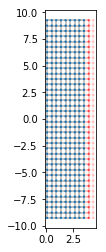

In [70]:
# Wsc must be multiples of eight
W=4
L=1
Lsc=20
syst = make_system(W=W, L=L, Lsc=Lsc)
# Check that the system looks as intended.
# kwant.plot(syst, colorbar=False,fig_size=(40,80),num_lead_cells=2)
kwant.plot(syst,num_lead_cells=2)
# Finalize the system.
syst = syst.finalized()

In [99]:
mu=0.18 #0.18
m=0
mu_sc= mu+t
Delta=0.03
t_j=1
phi=0.0095
gs=0.
gn=0.04
lam=0.5
U0=0
salt=1
V_j=0.

# momenta = [(-pi + 0.01 * pi * i)/5 for i in range(201)]
momenta=np.linspace(-1,1,100)*pi
params=dict(t_j=t_j, gs=gs, gn=gn, lam=lam, V_j=V_j, Delta=Delta, U0=U0, salt=salt, m=m, mu=mu ,mu_sc=mu_sc, phi=phi)


bands = kwant.physics.Bands(syst.leads[0], params=params)
energies = [bands(k) for k in momenta]

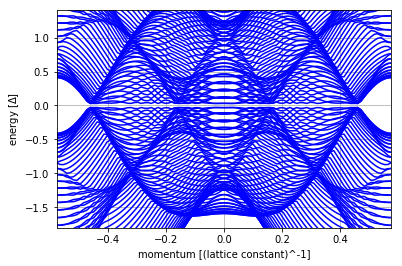

In [100]:
plt.figure()
plt.plot(np.array(momenta)/pi/sqrt(3), np.array(energies),'b')
# plt.plot((momenta), (energies))
plt.ylim(-1.8,1.4)
plt.xlim(-1/sqrt(3),1/sqrt(3))
plt.xlabel("momentum [(lattice constant)^-1]")
plt.ylabel(r"energy [$\Delta$]")
plt.grid()
plt.show()